## Training Notebook:

Currently Handles only case of single task - can be adapted for mutlitask output by summing across losses and taking a step back in that way: See --> https://towardsdatascience.com/tuning-a-multi-task-fate-grand-order-trained-pytorch-network-152cfda2e086

**Requirements:**

1) Pytorch and all subclasses (eg., nn and F) <br>
2) DontGetSNPpyWithMe.py in same folder as this notebook<br>
3) EarlyStop.py in same folder as this notebook 

**Import necessary packages:**

In [1]:
import torch 
import argparse
import os
import numpy as np
from torch.utils.data import DataLoader
from DontGetSNPpyWithMe import * #The neural net
import torch.optim as optim
import torch.nn.functional as F
from EarlyStop import * #Early Stopping object
from data_loader import *
import matplotlib.pyplot as plt

**Define a Validation Splitting Function (maybe handle externally by randomly sampling in a phenotype balanced way so can just read in and go here), and read in training, validation, and test (openSNP) data:**

Define variables that can be easily changed for model instantiation later in one place:

In [2]:
train_loader = get_loader(genotype_file="../data/2020_05_27/train_set.csv",
                          phenotype_file="../data/2020_05_27/train_labels.csv",
                          batch_size=32,
                          shuffle=False,
                          num_workers=4)
val_loader = get_loader(genotype_file="../data/2020_05_27/val_set.csv",
                          phenotype_file="../data/2020_05_27/val_labels.csv",
                          batch_size=32,
                          shuffle=False,
                          num_workers=4)
test_loader = get_loader(genotype_file="../data/2020_05_27/test_set.csv",
                          phenotype_file="../data/2020_05_27/test_labels.csv",
                          batch_size=32,
                          shuffle=False,
                          num_workers=4)

In [4]:
batchSize = 32
numSNPs= 276254  # 500000
numLayers = 5
layerWidths = [512, 512, 256, 128, 64]
dropout = 0.3
multitaskOutputs = [3]
learningRate = 5e-3
epochs = 100
patience = 5

Instantiate the model, loss function, and optimizer using the above parameters:

In [5]:
soHeavy = [1/1784, 1/224 , 1/5]  # 1/class_size for now

In [6]:
derekZoolander = DiddyKongRacing([batchSize,numSNPs], numLayers, layerWidths, dropout, multitaskOutputs)
optimizer = optim.Adam(derekZoolander.parameters(), lr=learningRate) # can add in regularization w/ wd as well later: weight_decay=1e-4) 



A ba ba boua ba ba: Layers are initializing...
Adding linear layer from 276254 nodes to 512 nodes...
Initializing Weights...
Adding linear layer from 512 nodes to 512 nodes...
Initializing Weights...
Adding linear layer from 512 nodes to 256 nodes...
Initializing Weights...
Adding linear layer from 256 nodes to 128 nodes...
Initializing Weights...
Adding linear layer from 128 nodes to 64 nodes...
Initializing Weights...
The angry aztec sends his llama regards: Multi-task layers initializing...
Adding multi-task linear layer from 64 nodes to 3 nodes
Initializing Weights...


Move the model to gpu if available:

In [7]:
pleaseBeGpu = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(pleaseBeGpu)
derekZoolander = derekZoolander.to(pleaseBeGpu)
torchMe = torch.FloatTensor(soHeavy).to(pleaseBeGpu)
criterion = nn.CrossEntropyLoss(weight=torchMe)  # Implement weighted loss

cuda


Define a Function to calc accuracy on a batch since the model returns raw outputs and not softmax!:

In [8]:
#input of 2 tensors --> make sure labels is a tensor of size == batch size
#output: Total number of matches (accuracy can be returned by removing the comment # below); 
# this was done to get accuracy on an epoch basis where can be weighted by total number of samples as opposed to a per batch basis
def AccuracyCalc(raw, labels): 
    #print(F.softmax(raw, dim = 1))
    payMeForMyPredictions = torch.argmax(F.softmax(raw, dim = 1), dim = 1)
    #print(payMeForMyPredictions)
    return sum(payMeForMyPredictions.eq(labels)).item() #/len(lables)

Define a validation (and Test) function (also base case of evaluation for epoch 0): 

Can mute print statements later when running everything especially with test set and when plotting is integrated but for now they are there to ensure things intuitively are working and can get a sense model is improving in real time.

In [10]:
#inputs: 1) model (derekZoolander) 2) current epoch number 3) validation dataloader 4) Loss function 5) device
#outputs: 1) accuracy 2) loss

def Validate(model, epochNum, data = val_loader, lossFn = criterion, device = pleaseBeGpu):
    model.eval() #shut off batch norm and dropout
    # numBatches = 0 in case want to know how many batches iterating through
    totalSamples = 0
    totalLoss = 0
    numerator = 0
    for i, (snpBatch, phenotypeBatch) in enumerate(data):            
        totalSamples += len(phenotypeBatch) #running total of number of samples

        #move labels to gpu (hopefully)
        snpBatch = snpBatch.to(device)
        phenotypeBatch = phenotypeBatch.to(device)

        #Run it:
        output = model(snpBatch)
        loss = lossFn(output[0], phenotypeBatch.squeeze(1)) #recall output returns a list to handle multi-task learning so here the prediction is output[0]

        #Calculate accuracy:
        numerator += AccuracyCalc(output[0], phenotypeBatch.squeeze(1))
        totalLoss += loss.item()
        
    epochAcc = numerator/(totalSamples)
    print("Validation accuracy at epoch {} is: {} .".format(epochNum,epochAcc))
    return epochAcc, totalLoss

Define a training f(x):

In [12]:
#Inputs: 1) model 2) Number of epochs want to train for 3) training dataloader 4) loss function 
# 5) the device available (cpu or gpu/cuda --> hopefully it is the latter)

#Outputs: 4 lists corresponding to a per epoch basis of accuracies and losses
# 1) Training Accs 2) Training Losses 3) Validation Accuracies 4) Validation Losses

def Train(model, numEpochs = epochs, data = train_loader, lossFn = criterion, device = pleaseBeGpu):
    
    #Lists of training accuracies and losses to return for visualization later
    losses = []
    accuracies = []
    
    #Lists of validation accuracies and losses to return for visualization later
    valAccs = []
    valLosses = []
    
    #Early stopping structures: 
    stop = EarlyStop(patience) #Create an EarlyStop object that will evaluate and save the best model if patience has been exceeded
    areWeThereYet = False #flag for condition of early stopping
    topDog = None #Best model to save if early stopping condition has been met
    
    for epoch in range(numEpochs):
        model.train() # turn on batch norm and dropout
        numerator = 0
        # numBatches = 0 in case want to know how many batches iterating through
        totalSamples = 0
        totalLoss = 0
        for i, (snpBatch, phenotypeBatch) in enumerate(data):
            #numBatches += 1 
            #print(snpBatch)
            #print(phenotypeBatch)
            totalSamples += len(phenotypeBatch) #running total of number of samples
            
            optimizer.zero_grad() #zero the gradient to prevent accumulation; apparently can also do model.zero_grad() as well and does the same thing...
            
            #move labels to gpu (hopefully)
            snpBatch = snpBatch.to(device)
            phenotypeBatch = phenotypeBatch.to(device)
            
            #Run it:
            output = model(snpBatch)
            loss = lossFn(output[0], phenotypeBatch.squeeze(1)) #recall output returns a list to handle multi-task learning so here the prediction is output[0]
            
            #Calculate accuracy:
            numerator += AccuracyCalc(output[0], phenotypeBatch.squeeze(1))
            totalLoss += loss.item()
            
            #Train it: 
            loss.backward()
            optimizer.step()

            
        epochAcc = numerator/(totalSamples)
        print("Training accuracy at epoch {} is: {} .".format(epoch+1,epochAcc))
        print("Training loss at epoch {} is : {} .".format(epoch+1, totalLoss))
        accuracies.append(epochAcc)
        losses.append(totalLoss)
        
        #Make some sort of call to Val when finished --> can discuss how want to do this of not a happy camper w/ this
        valAcc, valLoss = Validate(model, epoch + 1, data = val_loader)
        valAccs.append(valAcc)
        valLosses.append(valLoss)
        
        #Early Stopping: 
        areWeThereYet, topDog = stop(valLoss, model)
        if areWeThereYet:
            #Change this name later so can include hyperparametrs, etc
            torch.save(topDog.state_dict(), '../models/{}.pt'.format("BestModel_"+str(epoch) +"_epochs_" + str(numLayers) + "_hiddenLayers")) 
            print("Early stopping at epoch:" + str(epoch))
            break
        
        
    #Save final model if no early stopping
    if not areWeThereYet:
        print("Ugh didn't get to go home early, well lets save the final epoch model anyway.")
        torch.save(topDog.state_dict(), '../models/{}.pt'.format("BestModel_"+str(epochs) +"_epochs_" + str(numLayers) + "_hiddenLayers"))
    
    return accuracies, losses, valAccs, valLosses

In [13]:
# Test with dataloader
t_accs, t_losses, val_accs, val_losses \
    = Train(derekZoolander, numEpochs = epochs, data = train_loader, lossFn = criterion, device = pleaseBeGpu)

KeyError: Caught KeyError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 2890, in get_loc
    return self._engine.get_loc(key)
  File "pandas/_libs/index.pyx", line 107, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 131, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 1607, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 1614, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'HG04164'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/aklie/project/STR_crazy/bin/data_loader.py", line 27, in __getitem__
    X = torch.from_numpy(np.array(self.genotypes.loc[ID].values)).float()
  File "/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py", line 1410, in __getitem__
    return self._getitem_axis(maybe_callable, axis=axis)
  File "/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py", line 1825, in _getitem_axis
    return self._get_label(key, axis=axis)
  File "/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py", line 157, in _get_label
    return self.obj._xs(label, axis=axis)
  File "/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py", line 3738, in xs
    loc = self.index.get_loc(key)
  File "/opt/conda/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 2892, in get_loc
    return self._engine.get_loc(self._maybe_cast_indexer(key))
  File "pandas/_libs/index.pyx", line 107, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 131, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 1607, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 1614, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'HG04164'


Quick Test run to ensure skeleton code (should) work(s):

In [ ]:
training = training.to(pleaseBeGpu)
trainingLabels = trainingLabels.to(pleaseBeGpu)
print("Targets are: {}".format(trainingLabels.squeeze(1)))
print("\n")

derekZoolander.train()
optimizer.zero_grad()
print("Summary before simulated training: \n")
output = derekZoolander(training)
loss = criterion(output[0], trainingLabels.squeeze(1)) #recall output returns a list to handle multi-task learning so here the prediction is output[0]
            
#Calculate accuracy:
numerator = AccuracyCalc(output[0], trainingLabels.squeeze(1))
print(loss.item())
    
#Train it: 
loss.backward()
optimizer.step()

print("\n")
print("Summary after simulated training: \n")
output = derekZoolander(training)
loss = criterion(output[0], trainingLabels.squeeze(1)) #recall output returns a list to handle multi-task learning so here the prediction is output[0]


print(loss.item())

#Calculate accuracy:
numerator = AccuracyCalc(output[0], trainingLabels.squeeze(1))

**Seems to run properly!**

Main F(x) (or some sort of cohesive structure) and Plotting: Tbd

Text(0.5, 1.0, 'Loss on training set and holdout set vs. number of epochs')

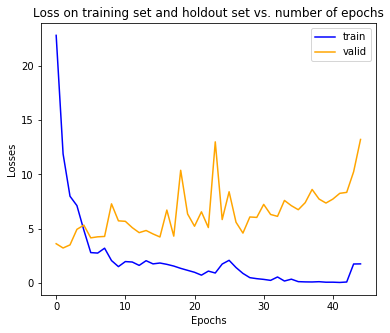

In [21]:
# Loss plotting
fig,ax = plt.subplots(figsize=(6,5))
ax.set_ylabel('Losses')
ax.set_xlabel('Epochs')
_=ax.plot(range(0, 44+1), t_losses,'b-',color="blue",label="train")
_=ax.plot(range(0, 44+1), val_losses,'b-',color="orange",label="valid")
plt.legend()
plt.title("Loss on training set and holdout set vs. number of epochs")

Text(0.5, 1.0, 'Loss on training set and holdout set vs. number of epochs')

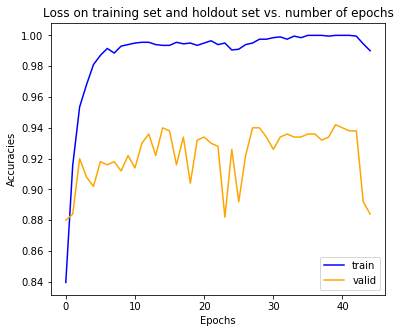

In [22]:
# Accuracy plotting
fig,ax = plt.subplots(figsize=(6,5))
ax.set_ylabel('Accuracies')
ax.set_xlabel('Epochs')
_=ax.plot(range(0, 44+1), t_accs,'b-',color="blue",label="train")
_=ax.plot(range(0, 44+1), val_accs,'b-',color="orange",label="valid")
plt.legend()
plt.title("Loss on training set and holdout set vs. number of epochs")

In [ ]:
test_acc, test_loss = Validate(derekZoolander, epochNum=0, data = test_loader, lossFn = criterion, device = pleaseBeGpu):